What they do is replace every pixel that needs to be removed with a weighted average of it's neighbours. Since some of it's 
neighbours might also need to be removed, we get system of linear equations that we have to solve, to find the new values of the pixels we want to replace.

​

A custom single metric that is a combination of Least Relevant First and Most Relevant First:

(Least Relevant First - Most Relevant First) / 2, accross different thresholds.

In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import io
import requests
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision.transforms as T

In [2]:
from road import ROADCombined

In [3]:
from EigenCAM import EigenCAM
from ScoreCAM import ScoreCAM
from AblationCAM import AblationCAM
from model_tragets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from functions import show_cam_on_image
import functions as func

In [4]:
# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("EigenCAM", EigenCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cg, attribution, use_rgb=True)
        print(name)
        print(score)
        print(" ")
        #visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


Resnet50 model and [model.layer4]

EigenCAM
-0.04022388
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [06:04<00:00,  5.70s/it]


AblationCAM
0.03170228
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:09<00:00,  2.89s/it]


ScoreCAM
0.009079248
 


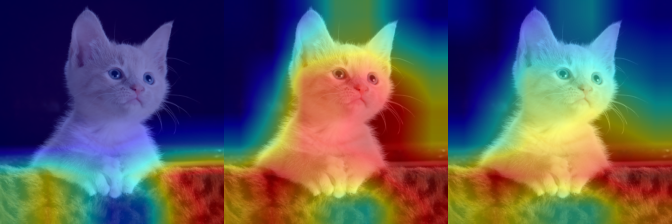

In [20]:
url = requests.get('https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=1600',stream=True)

iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (224, 224))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 224, 224,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

EigenCAM
-0.0001663649
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [05:24<00:00,  5.07s/it]


AblationCAM
-0.00013911631
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:10<00:00,  2.89s/it]


ScoreCAM
-1.1616823e-05
 


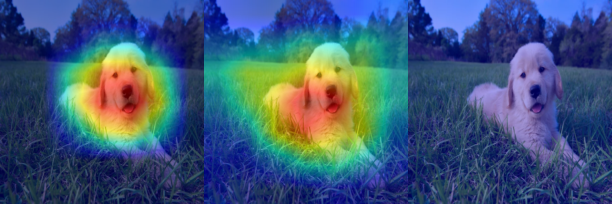

In [21]:
url = requests.get('https://www.southernliving.com/thmb/tXa6uF93OgesMpTj8UVX6HfMNZw=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-185743593-2000-507c6c8883a44851885ea4fbc10a2c9e.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting dog from the image

In [5]:
url = requests.get('C:\Users\sukan\Downloads\ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3055851738.py, line 1)

predicting cat from the image

EigenCAM
-0.011589018
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [05:09<00:00,  4.84s/it]


AblationCAM
0.029833412
 


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [04:55<00:00,  2.30s/it]


ScoreCAM
1.2152304e-07
 


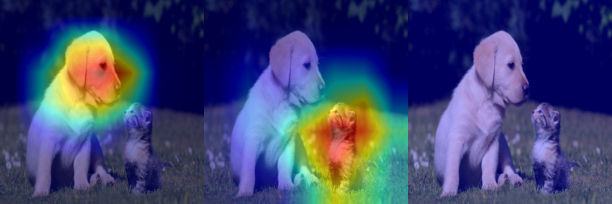

In [23]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet34 model and [model.layer4]

predicting dog from the image

EigenCAM
0.00012271671
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.45s/it]


AblationCAM
-1.5121195e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.17it/s]


ScoreCAM
-9.133392e-05
 


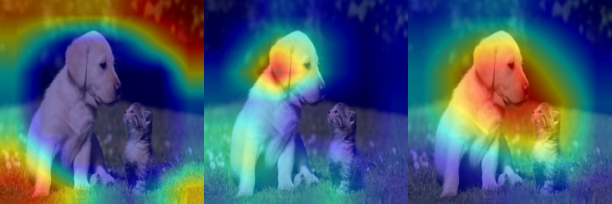

In [24]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting cat from the image

EigenCAM
-0.00039875935
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.46s/it]


AblationCAM
0.0109836785
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.08it/s]


ScoreCAM
0.006954447
 


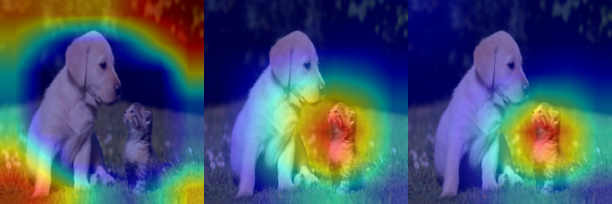

In [25]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet50 model and [model.layer3]

predicting dog from the image

EigenCAM
-0.00014137794
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:17<00:00,  4.31s/it]


AblationCAM
3.7515296e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:45<00:00,  1.64s/it]


ScoreCAM
2.5708287e-06
 


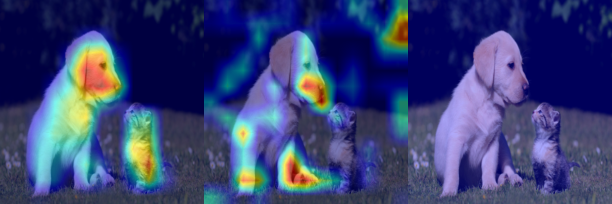

In [26]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting cat from the image

EigenCAM
0.00038724576
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:10<00:00,  4.07s/it]


AblationCAM
0.026067497
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:01<00:00,  2.84s/it]


ScoreCAM
2.4376786e-06
 


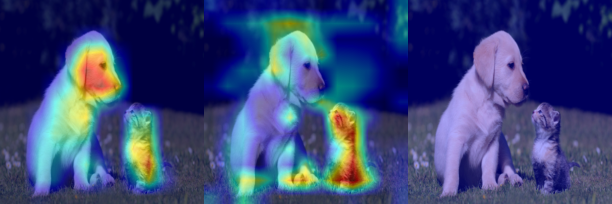

In [27]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

Resnet34 model and [model.layer3]

predicting dog from the image

EigenCAM
5.893834e-05
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.43s/it]


AblationCAM
9.157519e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.71s/it]


ScoreCAM
-5.194378e-05
 


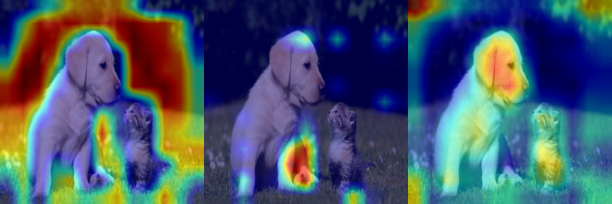

In [28]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting cat from the image

EigenCAM
-0.0005902762
 


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.43s/it]


AblationCAM
0.0026320159
 


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.69s/it]


ScoreCAM
0.0007747331
 


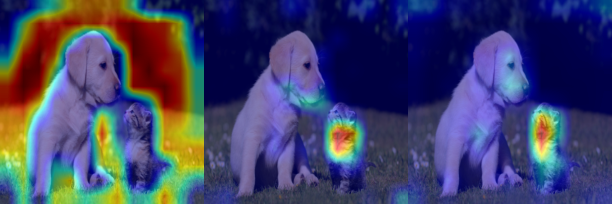

In [29]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.resnet34(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])

cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

densenet121 and denseblock4 layer

predicting dog from the image

EigenCAM
-2.6901336e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:59<00:00,  3.75s/it]


AblationCAM
-1.2167537e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:37<00:00,  1.52s/it]


ScoreCAM
0.00024539337
 


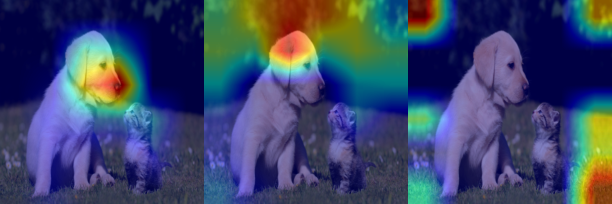

In [30]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])

cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting cat from the image

EigenCAM
-0.00011432347
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:12<00:00,  4.15s/it]


AblationCAM
0.015836475
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:37<00:00,  1.53s/it]


ScoreCAM
0.035041407
 


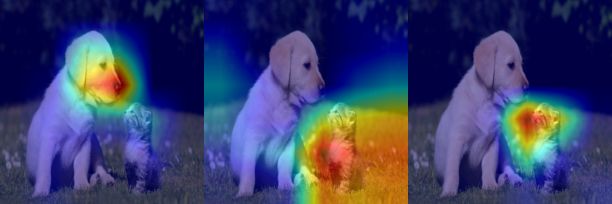

In [31]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])

cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

densenet121 and denseblock3 layer

predicting dog from the image

EigenCAM
1.9424493e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:42<00:00,  3.19s/it]


AblationCAM
3.0628453e-06
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:46<00:00,  2.59s/it]


ScoreCAM
-2.6562906e-05
 


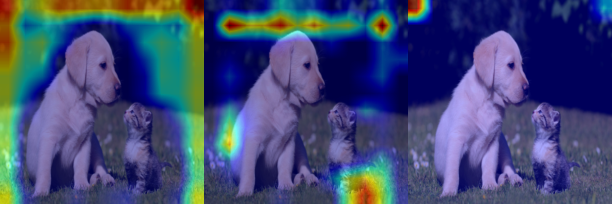

In [32]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])

cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=246)

predicting cat from the image

EigenCAM
1.1524171e-05
 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [02:32<00:00,  4.75s/it]


AblationCAM
0.0151715465
 


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:45<00:00,  2.58s/it]


ScoreCAM
0.001628408
 


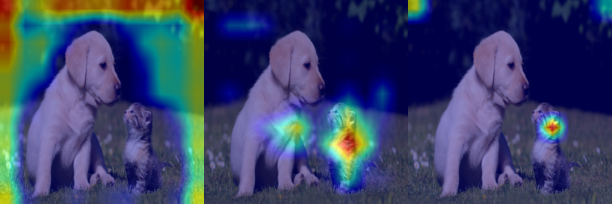

In [33]:
url = requests.get('https://wallpaper-house.com/data/out/8/wallpaper2you_272733.jpg',stream=True)
model = models.densenet121(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)

img = np.array(image)
tensor = tensor.reshape([ 204, 204,3])

cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.features.denseblock3]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)